# Expectation Maximisation (EM) Algorithm
Got the EM codes from
https://www.ritchievink.com/blog/2019/05/24/algorithm-breakdown-expectation-maximization/

Compared it with MLE of extended likelihood (marked unbinned likelihood)

Pueh Leng Tan, 25 August 2025

In [1]:
import numpy as np
import scipy.stats as sps
import scipy.optimize as spo

import matplotlib.pyplot as plt

In [2]:
np.random.seed(654)

n_samples = 1000
mu_true = [2., 5.]
sigma_true = [1., 1.8]
phi_true = 0.75

In [3]:
# Draw samples from two Gaussian w.p. z_i ~ Bernoulli(phi)

generative_m = []
for _mu, _sigma in zip(mu_true, sigma_true):
    generative_m.append(sps.norm(_mu, _sigma))
generative_m = np.array(generative_m)

z_i = sps.bernoulli(phi_true).rvs(n_samples)
x_i = np.array([g.rvs() for g in generative_m[z_i]])

mc_truth_vector = [*mu_true, *sigma_true, n_samples-z_i.sum(), z_i.sum()]

In [4]:
def visualise(data, bf, mc_truth):
    mu1, mu2, sigma1, sigma2, n1, n2 = mc_truth
    mu1_bf, mu2_bf, sigma1_bf, sigma2_bf, n1_bf, n2_bf = bf
    
    x = np.linspace(-5, 12, 150)   
    
    f1 = n1_bf*sps.norm.pdf(x, loc=mu1_bf, scale=sigma1_bf)/(n1_bf+n2_bf)
    truth = n1*sps.norm.pdf(x, loc=mu1, scale=sigma1)/(n1+n2)
    plt.plot(x, f1, label='Component 1')
    plt.plot(x, truth, lw=1, ls='-.', color='black')

    f2 = n2_bf*sps.norm.pdf(x, loc=mu2_bf, scale=sigma2_bf)/(n1_bf+n2_bf)
    truth = n2*sps.norm.pdf(x, loc=mu2, scale=sigma2)/(n1+n2)
    plt.plot(x, f2, label='Component 2')
    plt.plot(x, truth, lw=1, ls='-.', color='black', label='MC truth')
    
    plt.vlines(data, 0, 0.01, color=np.array(['C0', 'C1'])[z_i], label='Events')
    
    plt.legend()
    plt.xlabel('Observable, X')
    plt.ylabel('PDF')

    return None

In [5]:
class EM:
    def __init__(self, k):
        self.k = k
        self.mu = None
        self.std = np.ones(k)
        self.w_ij = None
        self.phi = np.ones(k) / k
        return None

    def expectation_step(self, x):
        for z_i in range(self.k):
            self.w_ij[z_i] = sps.norm(self.mu[z_i], self.std[z_i]).pdf(x) * self.phi[z_i]
    	# normalize zo that marginalizing z would lead to p = 1
        self.w_ij /= self.w_ij.sum(0)
        return None

    def maximization_step(self, x):
        self.phi = self.w_ij.mean(1)
        self.std = ((self.w_ij * (x - self.mu[:, None])**2).sum(1) / self.w_ij.sum(1))**0.5
        self.mu = (self.w_ij * x).sum(1) / self.w_ij.sum(1)
        return None
        
    def fit(self, x, debug=False):
        self.mu = np.random.uniform(x.min(), x.max(), size=self.k)
        self.w_ij = np.zeros((self.k, x.shape[0]))

        last_mu = np.ones(self.k) * np.inf
        output = []
        while ~np.all(np.isclose(self.mu, last_mu)):
            last_mu = self.mu
            self.expectation_step(x)
            self.maximization_step(x)
            if debug:
                tmp = np.sum((last_mu-self.mu)**2.)
                output.append(tmp)
        return output

    def termination_condition(self, last_mu, atol=1e-8):
        '''
        Returns True if termination condition has been reached.
        '''
        cond = np.nansum(last_mu-self.mu)
        return (cond<atol)

In [6]:
test_k = 2
model = EM(test_k) # you have to pick a k

#model.fit(x_i)
#model.fit2(x_i, max_iter=5000)

In [7]:
model.phi

array([0.5, 0.5])

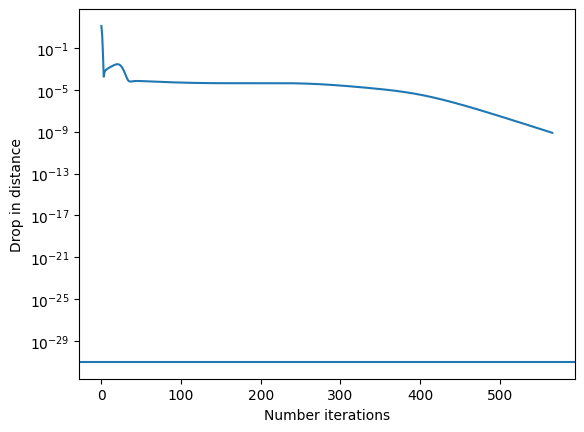

In [8]:
test_rtol = 1e-31
zz = model.fit(x_i, debug=True)

plt.plot(zz)
plt.xlabel('Number iterations')
plt.ylabel('Drop in distance')
plt.yscale('log')
plt.axhline(test_rtol)

Text(0.5, 1.0, 'EM algorithm')

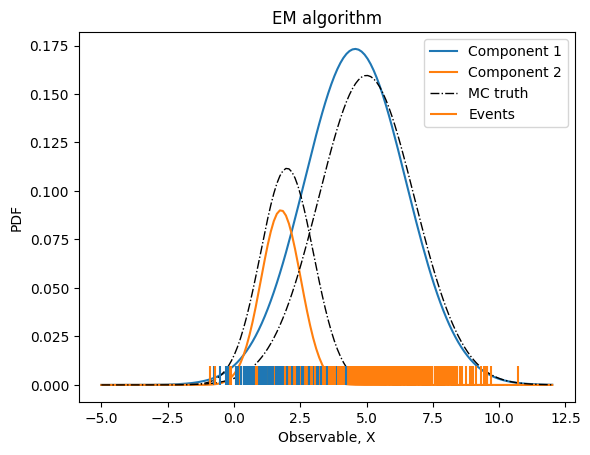

In [27]:
visualise(x_i, [*model.mu, *model.std, model.phi[0]*len(x_i), model.phi[1]*len(x_i)], mc_truth_vector)
plt.title('EM algorithm')

In [ ]:
raise

## MLE using marked unbinned likelihood

In [9]:
def my_lh_template(params, data=None):
    assert data is not None, 'wtf. where is your data?'
    #mu1, mu2 = mu_true
    sigma1, sigma2 = sigma_true
    #sigma1 = sigma_true[0]
    
    #mu1, mu2, sigma1, sigma2, n1, n2 = params
    #mu1, mu2, sigma2, n1, n2 = params
    mu1, mu2, n1, n2 = params
    
    tmp1 = sps.norm.pdf(data, loc=mu1, scale=sigma1)
    tmp2 = sps.norm.pdf(data, loc=mu2, scale=sigma2)

    #output = np.sum(np.log((n1*tmp1 + n2*tmp2)/(n1+n2)))
    output = np.sum(np.log(n1*tmp1 + n2*tmp2))
    output -= len(data)*np.log(n1+n2)
    
    output += sps.poisson.logpmf(len(data), mu=n1+n2)
    return -2.*output

In [10]:
def my_lh_2params(params, data=None):
    assert data is not None, 'wtf. where is your data?'
    mu1, mu2 = mu_true
    sigma1, sigma2 = sigma_true
    
    n1, n2 = params
    
    tmp1 = sps.norm.pdf(data, loc=mu1, scale=sigma1)
    tmp2 = sps.norm.pdf(data, loc=mu2, scale=sigma2)

    #output = np.sum(np.log((n1*tmp1 + n2*tmp2)/(n1+n2)))
    output = np.sum(np.log(n1*tmp1 + n2*tmp2))
    output -= len(data)*np.log(n1+n2)
    
    output += sps.poisson.logpmf(len(data), mu=n1+n2)
    return -2.*output

my_x0_2params = np.array([len(x_i)/2., len(x_i)-len(x_i)/2.])

In [11]:
def my_lh_4params(params, data=None):
    assert data is not None, 'wtf. where is your data?'
    
    sigma1, sigma2 = sigma_true
    mu1, mu2, n1, n2 = params
    
    tmp1 = sps.norm.pdf(data, loc=mu1, scale=sigma1)
    tmp2 = sps.norm.pdf(data, loc=mu2, scale=sigma2)

    #output = np.sum(np.log((n1*tmp1 + n2*tmp2)/(n1+n2)))
    output = np.sum(np.log(n1*tmp1 + n2*tmp2))
    output -= len(data)*np.log(n1+n2)
    
    output += sps.poisson.logpmf(len(data), mu=n1+n2)
    return -2.*output

my_x0_4params = np.array([np.mean(x_i), np.mean(x_i), len(x_i)/2., len(x_i)-len(x_i)/2.])

In [12]:
def my_lh_5params(params, data=None):
    assert data is not None, 'wtf. where is your data?'

    sigma1 = sigma_true[0]
    mu1, mu2, sigma2, n1, n2 = params

    tmp1 = sps.norm.pdf(data, loc=mu1, scale=sigma1)
    tmp2 = sps.norm.pdf(data, loc=mu2, scale=sigma2)

    #output = np.sum(np.log((n1*tmp1 + n2*tmp2)/(n1+n2)))
    output = np.sum(np.log(n1*tmp1 + n2*tmp2))
    output -= len(data)*np.log(n1+n2)
    
    output += sps.poisson.logpmf(len(data), mu=n1+n2)
    return -2.*output

my_x0_5params = np.array([np.mean(x_i), np.mean(x_i), np.std(x_i), len(x_i)/2., len(x_i)-len(x_i)/2.])

In [13]:
def my_lh_5paramsb(params, data=None):
    assert data is not None, 'wtf. where is your data?'

    sigma1 = sigma_true[1]
    mu1, mu2, sigma2, n1, n2 = params

    tmp1 = sps.norm.pdf(data, loc=mu1, scale=sigma1)
    tmp2 = sps.norm.pdf(data, loc=mu2, scale=sigma2)

    #output = np.sum(np.log((n1*tmp1 + n2*tmp2)/(n1+n2)))
    output = np.sum(np.log(n1*tmp1 + n2*tmp2))
    output -= len(data)*np.log(n1+n2)
    
    output += sps.poisson.logpmf(len(data), mu=n1+n2)
    return -2.*output

my_x0_5params = np.array([np.mean(x_i), np.mean(x_i), np.std(x_i), len(x_i)/2., len(x_i)-len(x_i)/2.])

In [14]:
def my_lh_6params(params, data=None):
    assert data is not None, 'wtf. where is your data?'

    mu1, mu2, sigma1, sigma2, n1, n2 = params
    
    tmp1 = sps.norm.pdf(data, loc=mu1, scale=sigma1)
    tmp2 = sps.norm.pdf(data, loc=mu2, scale=sigma2)

    #output = np.sum(np.log((n1*tmp1 + n2*tmp2)/(n1+n2)))
    output = np.sum(np.log(n1*tmp1 + n2*tmp2))
    output -= len(data)*np.log(n1+n2)
    
    output += sps.poisson.logpmf(len(data), mu=n1+n2)
    return -2.*output

my_x0_6params = np.array([np.mean(x_i), np.mean(x_i), np.std(x_i), np.std(x_i), len(x_i)/2., len(x_i)-len(x_i)/2.])

In [15]:
res2 = spo.minimize(my_lh_2params, 
                    x0=my_x0_2params,
                    args=(x_i,),
                    method='trust-constr')
res2.success, res2.x

(True, array([285.1564906 , 714.84350708]))

In [16]:
n_samples-np.sum(z_i), np.sum(z_i)

(np.int64(280), np.int64(720))

In [17]:
res4 = spo.minimize(my_lh_4params, 
                    x0=my_x0_4params,
                    args=(x_i,),
                    method='trust-constr')
res4.success, res4.x

(True, array([  1.99016155,   4.84186824, 260.63677693, 739.36184902]))

In [18]:
mu_true, n_samples-np.sum(z_i), np.sum(z_i)

([2.0, 5.0], np.int64(280), np.int64(720))

In [19]:
res5 = spo.minimize(my_lh_5params, 
                    x0=my_x0_5params,
                    args=(x_i,),
                    method='trust-constr')
res5.success, res5.x

/home/peaelle42/miniconda3/envs/py311/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


(True,
 array([  1.98858787,   4.81204571,   1.82385356, 252.68158136,
        747.32004436]))

In [20]:
mu_true, sigma_true[1], n_samples-np.sum(z_i), np.sum(z_i)

([2.0, 5.0], 1.8, np.int64(280), np.int64(720))

In [21]:
res5b = spo.minimize(my_lh_5paramsb, 
                    x0=my_x0_5params,
                    args=(x_i,),
                    method='trust-constr')
res5b.success, res5b.x

(True,
 array([  3.56142519,   6.71247247,   1.25245949, 829.51560576,
        170.47857503]))

In [22]:
*mu_true, sigma_true[0], n_samples-np.sum(z_i), np.sum(z_i)

(2.0, 5.0, 1.0, np.int64(280), np.int64(720))

In [23]:
res6 = spo.minimize(my_lh_6params, 
                    x0=my_x0_6params,
                    args=(x_i,),
                    method='trust-constr')
res6.success, res6.x

(True,
 array([  4.09860932,   4.09860932,   2.0585016 ,   2.0585016 ,
        500.        , 500.        ]))

In [24]:
mu_true, sigma_true, n_samples-np.sum(z_i), np.sum(z_i)

([2.0, 5.0], [1.0, 1.8], np.int64(280), np.int64(720))

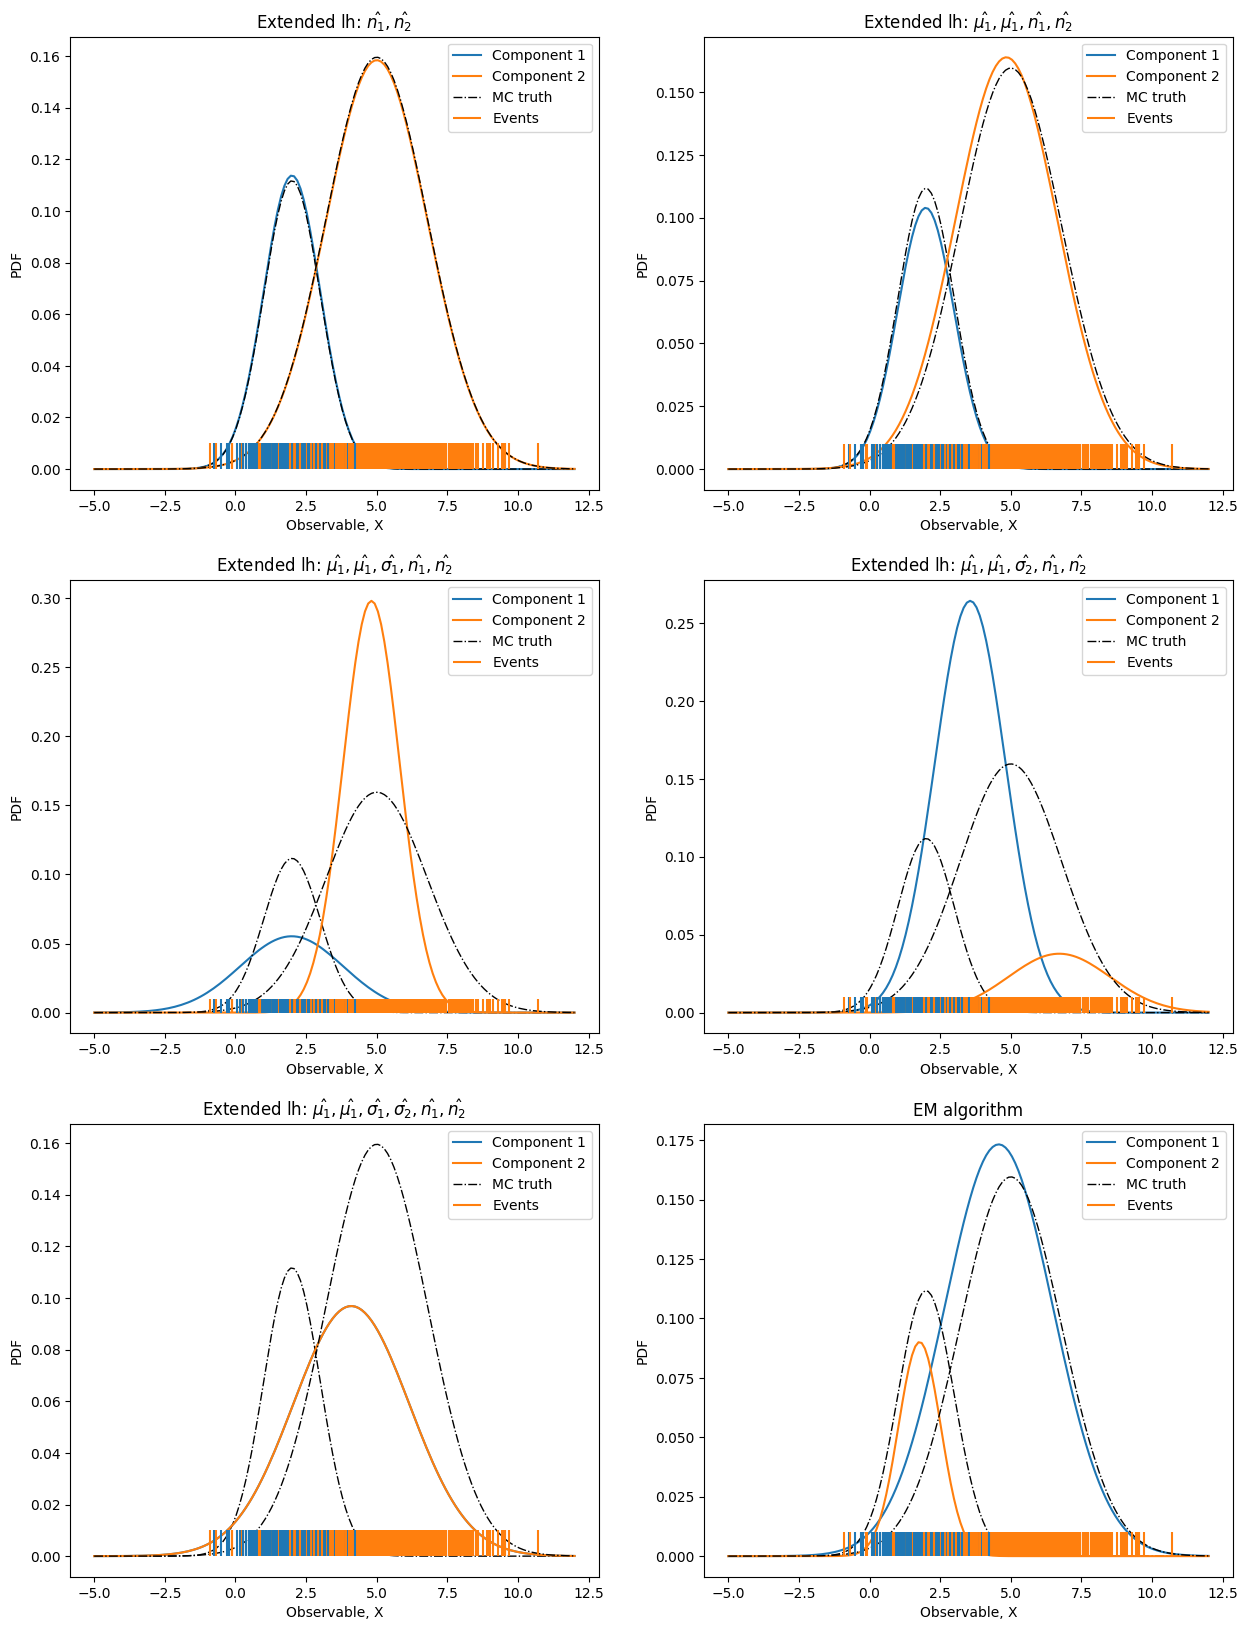

In [28]:
plt.figure(figsize=(15, 20))

plt.subplot(321)
visualise(x_i, [*mu_true, *sigma_true, *res2.x], mc_truth_vector)
plt.title('Extended lh: $\hat{n_1}, \hat{n_2}$')

plt.subplot(322)
visualise(x_i, [*res4.x[:2], *sigma_true, *res4.x[2:]], mc_truth_vector)
plt.title('Extended lh: $\hat{\mu_1}, \hat{\mu_1}, \hat{n_1}, \hat{n_2}$')

plt.subplot(323)
visualise(x_i, [*res5.x[:3], sigma_true[0], *res5.x[3:]], mc_truth_vector)
plt.title('Extended lh: $\hat{\mu_1}, \hat{\mu_1}, \hat{\sigma_1}, \hat{n_1}, \hat{n_2}$')

plt.subplot(324)
visualise(x_i, [*res5b.x[:3], sigma_true[1], *res5b.x[3:]], mc_truth_vector)
plt.title('Extended lh: $\hat{\mu_1}, \hat{\mu_1}, \hat{\sigma_2}, \hat{n_1}, \hat{n_2}$')

plt.subplot(325)
visualise(x_i, res6.x, mc_truth_vector)
plt.title('Extended lh: $\hat{\mu_1}, \hat{\mu_1},\hat{\sigma_1}, \hat{\sigma_2}, \hat{n_1}, \hat{n_2}$')

plt.subplot(326)
visualise(x_i, [*model.mu, *model.std, model.phi[0]*len(x_i), model.phi[1]*len(x_i)], mc_truth_vector)
plt.title('EM algorithm')

plt.savefig('extendedlh_em_comparison.png')